In [25]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import argparse
import cv2
import os
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths


In [26]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
EPOCHS = 25
covid = []
healty = []
data = []
labels = []

print("loading positive images...")
imageCovidPaths = list(paths.list_images('data/covid'))
for imagePath in imageCovidPaths:    
    label = 'covid'   
    
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    
    covid.append(image)
    data.append(image)
    labels.append(label)

print("loading negative images...")    
imagePaths = list(paths.list_images('data/healty'))
for imagePath in imagePaths:    
    label = 'healty' 
    
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    
    healty.append(image)
    data.append(image)
    labels.append(label)    
    

data = np.array(data) / 255.0
labels = np.array(labels)

loading positive images...
loading negative images...


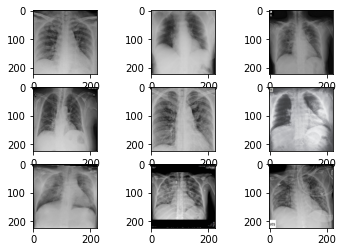

In [27]:
#Show sample of healty covid
f, axarr = plt.subplots(3,3)
axarr[0,0].imshow(covid[0])
axarr[0,1].imshow(covid[1])
axarr[0,2].imshow(covid[2])
axarr[1,0].imshow(covid[3])
axarr[1,1].imshow(covid[4])
axarr[1,2].imshow(covid[5])
axarr[2,0].imshow(covid[6])
axarr[2,1].imshow(covid[7])
axarr[2,2].imshow(covid[8])

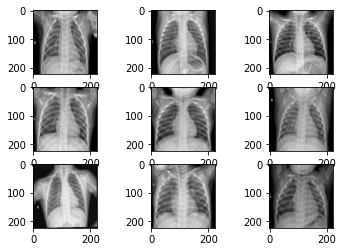

In [28]:
#Show sample of healty cases
f, axarr = plt.subplots(3,3)
axarr[0,0].imshow(healty[0])
axarr[0,1].imshow(healty[1])
axarr[0,2].imshow(healty[2])
axarr[1,0].imshow(healty[3])
axarr[1,1].imshow(healty[4])
axarr[1,2].imshow(healty[5])
axarr[2,0].imshow(healty[6])
axarr[2,1].imshow(healty[7])
axarr[2,2].imshow(healty[8])


In [29]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels); #print(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=36)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

In [30]:
# load the VGG16 network
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

In [31]:
LEARNINGRATE = 1e-3

# compile the model
opt = Adam(lr=LEARNINGRATE, decay=LEARNINGRATE / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

print("Training...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=8),
    steps_per_epoch=len(trainX) // 8,
    validation_data=(testX, testY),
    validation_steps=len(testX) // 8,
    epochs=EPOCHS)

Training...
Epoch 1/25
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
11/11 [==============================] - 10s 915ms/step - loss: 0.9757 - accuracy: 0.4353 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/25
11/11 [==============================] - 8s 720ms/step - loss: 0.7545 - accuracy: 0.5529 - val_loss: 0.6033 - val_accuracy: 0.7500
Epoch 3/25
11/11 [==============================] - 8s 710ms/step - loss: 0.7623 - accuracy: 0.5412 - val_loss: 0.5722 - val_accuracy: 0.8333
Epoch 4/25
11/11 [==============================] - 8s 715ms/step - loss: 0.6779 - accuracy: 0.5882 - val_loss: 0.5547 - val_accuracy: 0.7500
Epoch 5/25
11/11 [==============================] - 8s 742ms/step - loss: 0.6727 - accuracy: 0.6136 - val_loss: 0.4941 - val_accuracy: 0.9167
Epoch 6/25
11/11 [==============================] - 8s 696ms/step - loss: 0.5171 - accuracy: 0.7195 - val_loss: 0.4351 - val_accuracy: 0.9583
Epoch 7/25
11/11 [=======================

In [32]:
# make predictions on the testing set
print("Evaluating network...")
predIdxs = model.predict(testX, batch_size=8)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))


Evaluating network...
              precision    recall  f1-score   support

       covid       0.92      1.00      0.96        12
      healty       1.00      0.92      0.96        12

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24



In [33]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[12  0]
 [ 1 11]]
acc: 0.9583
sensitivity: 1.0000
specificity: 0.9167


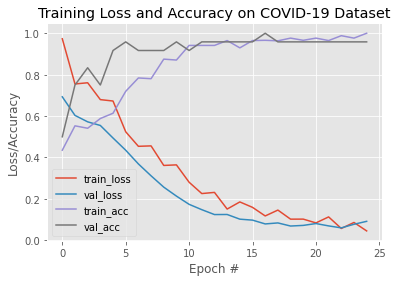

In [34]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")